In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import pandas as pd

In [2]:
datagfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#GFP_corrected")
datarfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#RFP")

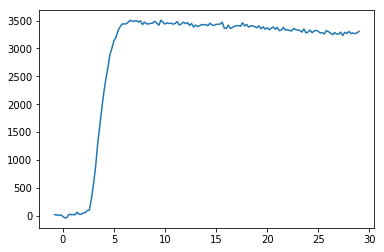

In [3]:
plt.plot(datagfp["Time [h]"],datagfp["#10^3 molecules eGFP crosstalk corrected.2"])

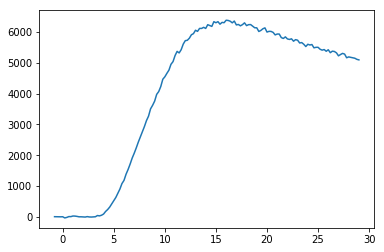

In [4]:
t = datarfp["Time [h]"]
tt = datarfp["Time [h]"]
data = datarfp["#10^3 molecules CayRFP.2"]
noise = np.sqrt(np.abs(data))
plt.plot(t,data)

In [5]:
def DE(t, t0, m, k, beta, delta, offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset


In [22]:
m_ktl_0 = 2e4

tr_0 = 4.5
kmr_0 = 0.3
betr_0 = 0.0421
deltr_0 = 0.03
offr_0 = 0

DE_model = lm.Model(DE)
pars = DE_model.make_params()
pars['t0'].set(value=tr_0,vary=True)
pars['m'].set(value=m_ktl_0,vary=True)
pars['k'].set(value=kmr_0,vary=False)
pars['beta'].set(value=betr_0,vary=False)
pars['delta'].set(value=deltr_0,vary=True)
pars['offset'].set(value=offr_0,vary=True)

out = DE_model.fit(data, pars, t=tt, weights=1/noise)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(DE)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 150
    # variables        = 4
    chi-square         = 780.974974
    reduced chi-square = 5.34914366
    Akaike info crit   = 255.486172
    Bayesian info crit = 267.528713
[[Variables]]
    t0:      3.58069143 +/- 0.02829201 (0.79%) (init = 4.5)
    m:       2352.13642 +/- 33.5300421 (1.43%) (init = 20000)
    k:       0.3 (fixed)
    beta:    0.0421 (fixed)
    delta:   0.20469593 +/- 0.00342056 (1.67%) (init = 0.03)
    offset:  0.87442986 +/- 0.68056390 (77.83%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(m, delta)  =  0.977
    C(t0, m)     =  0.735
    C(t0, delta) =  0.714



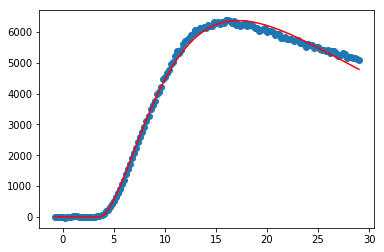

In [7]:
plt.plot(t,data,"o")
plt.plot(t, out.best_fit, 'r-')

In [8]:
import pymc as pm

In [9]:
m_ktl_0 = 2e4
m_ktl_max = 5e5

tr_0 = 4.5

kmr_0 = 0.3
kmr_sigma = 0.08

betr_0 = 0.0421
betr_sigma = 0.013

deltr_0 = 0.03
offr_0 = 0

t0 = pm.Uniform('t0',lower=0,upper=20)
m = pm.Uniform('m',lower = 1, upper = m_ktl_max)
k = pm.Uniform('k',lower = 0, upper = kmr_0*5)
beta = pm.Uniform('beta',lower =0, upper = betr_0*5)
delta = pm.Uniform('delta',lower=0,upper=1)
offset = pm.Uniform('offset',lower=0,upper=50.0)

@pm.deterministic
def DE_pm(t=tt, t0=t0, m=m, k=k, beta=beta, delta=delta, offset=offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset

obs = pm.Normal('obs', mu=DE_pm, tau=1/noise**2, observed=True,
                value=data)

 [-----------------100%-----------------] 150000 of 150000 complete in 7227.4 sec

(array([  1.09000000e+02,   1.38100000e+03,   8.31700000e+03,
          2.33180000e+04,   3.15260000e+04,   2.32360000e+04,
          9.67500000e+03,   2.18300000e+03,   2.42000000e+02,
          1.30000000e+01]),
 array([ 3.57667707,  3.59164286,  3.60660866,  3.62157445,  3.63654025,
         3.65150604,  3.66647183,  3.68143763,  3.69640342,  3.71136922,
         3.72633501]),
 <a list of 10 Patch objects>)

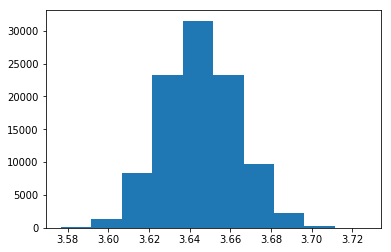

In [10]:
SAMPLES = 100000
BURN = 50000

model = pm.Model([t0, m, k, beta, delta,offset,obs])
mcmc = pm.MCMC(model)
mcmc.sample(SAMPLES + BURN, BURN)

plt.hist(mcmc.trace('t0')[:])

Plotting beta
Plotting delta
Plotting offset
Plotting t0
Plotting m
Plotting k


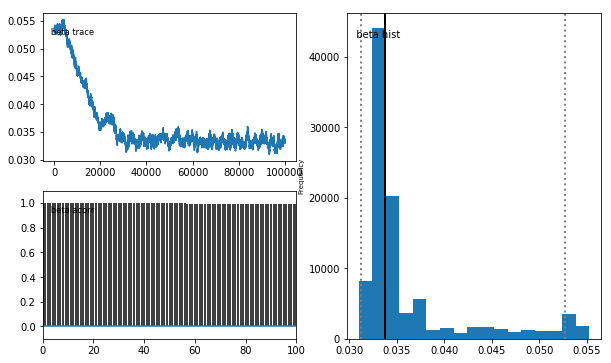

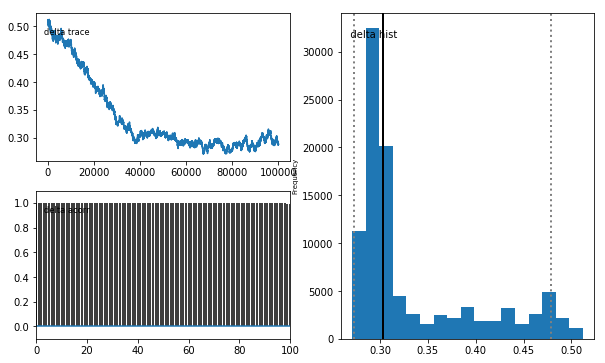

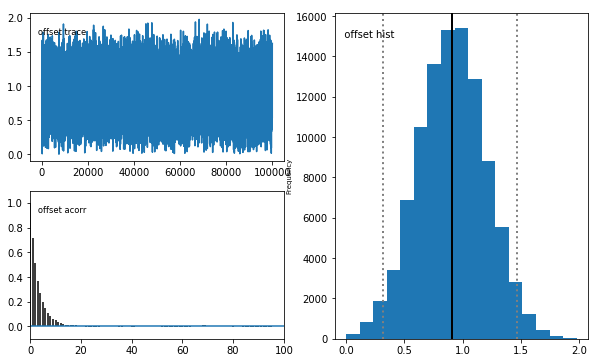

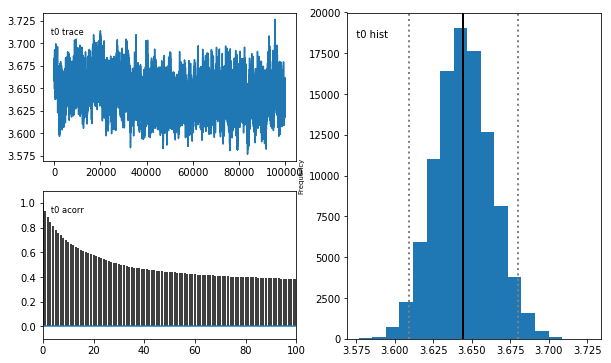

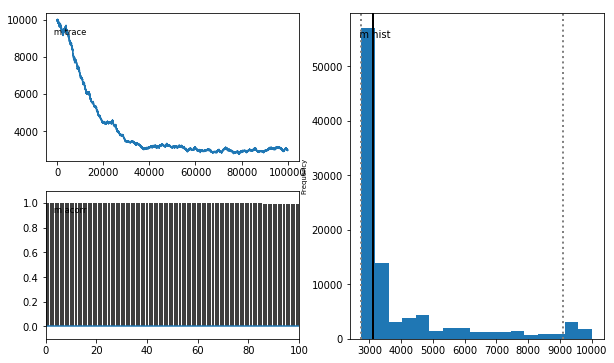

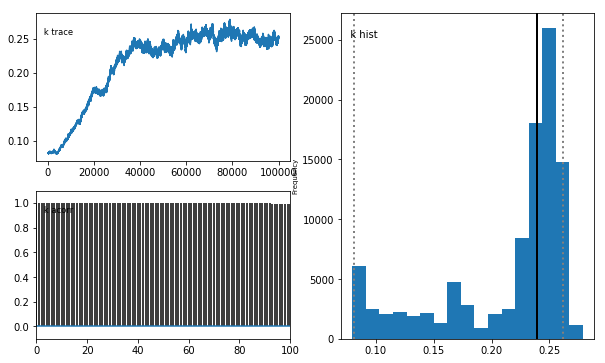

In [11]:
pm.Matplot.plot(mcmc)

In [12]:
mcmc.summary()


beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.036            0.006            0.001            [ 0.031  0.053]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.032            0.033           0.034          0.036         0.054
	

delta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.335            0.066            0.007            [ 0.273  0.479]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.277            0.29            0.304          0.37          0.487
	

offset:
 
	Mean             SD               MC Error        95% HPD interval
	---------------------

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [20]:
t_eq = 40000
print("delta: ",np.percentile(mcmc.trace('delta')[t_eq:],[2.5,25,50,75,97.5]))
print("k: ",np.percentile(mcmc.trace('k')[t_eq:],[2.5,25,50,75,97.5]))
print("beta: ",np.percentile(mcmc.trace('beta')[t_eq:],[2.5,25,50,75,97.5]))
print("m: ",np.percentile(mcmc.trace('m')[t_eq:],[2.5,25,50,75,97.5]))
print("offset: ",np.percentile(mcmc.trace('offset')[t_eq:],[2.5,25,50,75,97.5]))
print("t0: ",np.percentile(mcmc.trace('t0')[t_eq:],[2.5,25,50,75,97.5]))

delta:  [ 0.27580603  0.28669424  0.2924381   0.30198809  0.31128846]
k:  [ 0.22792457  0.24100069  0.24905564  0.25593491  0.2662524 ]
beta:  [ 0.03187369  0.0327813   0.0333174   0.03386851  0.03499243]
m:  [ 2830.89331753  2919.58178297  2991.82423194  3110.83070509  3241.84611922]
offset:  [ 0.32560957  0.70891887  0.90742647  1.09599029  1.47999995]
t0:  [ 3.60782445  3.62877316  3.64045315  3.65190063  3.67489048]


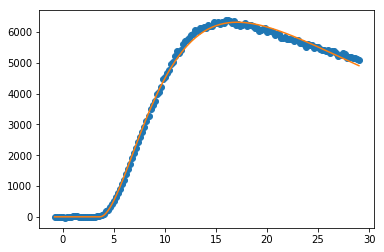

In [24]:
MC_fit = DE(t=tt,
            t0=mcmc.trace('t0')[t_eq:].mean(),
           beta=mcmc.trace('beta')[t_eq:].mean(),
           delta=mcmc.trace('delta')[t_eq:].mean(),
            k=mcmc.trace('k')[t_eq:].mean(),
            m=mcmc.trace('m')[t_eq:].mean(),
            offset=mcmc.trace('offset')[t_eq:].mean()
           )
plt.plot(tt,data,"o")
plt.plot(tt,MC_fit)